# Model feature analysis of 3D objects

As a starting point, we extract features of the stimuli we used in the neurosketch study: four cars, four furniture items.
We use VGG16 as our feature extractor.  This will allow us to directly relate these object stimuli to our sketch data using the same feature embedding. Later, we will use these embeddings to connect to the neural data. 


In [5]:
# here are some set up code to ignore 
import numpy as np
import utils
import pickle
import scipy
from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split



%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# Constants 

# I pulled activations of 8 layers. Here is the index ref to the layers
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6, 'prob': 7}

# constants for the images
NUM_VIEWS = 40
CARS = ['limo', 'suv', 'smart', 'sedan']
FURNITURES = ['bed', 'chair', 'table', 'bench']
OBJECTS = CARS + FURNITURES
# sample image url: https://s3.amazonaws.com/morphrecog-images-1/limoToSUV_10_10_99.png.png
# CARS_label = ['limoToSUV_10','limoToSUV_99','smartToSedan_10','smartToSedan_99'];
# FIURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']

 

# constants for train/test for the linear discriminability
TRAIN_SZ = 0.80
TEST_SZ = 1 - TRAIN_SZ


In [7]:
# pulling/cleaning up the data

# downloading the activations. I had to split the sample (each act has 160 images) because they're about 3GB each. 
act1 = pickle.load(open('activations.p', 'rb'))
act2 = pickle.load(open('activations2.p', 'rb'))

In [8]:
# pulling out all the fc6, fc7 layers for all images to have a smaller set to work with. 
fc6 = np.vstack((np.asarray(act1[LAYERS['fc6']]), np.asarray(act2[LAYERS['fc6']])))
fc7 = np.vstack((np.asarray(act1[LAYERS['fc7']]), np.asarray(act2[LAYERS['fc7']])))


# pulling out remaining pooling layers
pool = [] 

for i in xrange(0,5):
    pool1_i, pool2_i = np.asarray(act1[i]), np.asarray(act2[i])

    pool_i = np.vstack((pool1_i.reshape(pool1_i.shape[0], pool1_i.shape[1] * pool1_i.shape[2] * pool1_i.shape[3]), 
                     pool2_i.reshape(pool2_i.shape[0], pool2_i.shape[1] * pool2_i.shape[2] * pool2_i.shape[3])))
    pool.append(pool_i)



## 1. Representational Similarity Analysis

We want to relate the model's feature representation of the actual 3D objects participants viewed to its representation of the sketches people produced during training. As a first step, we analyze the category-level and object-level similarity for the 3D objects, at each layer of VGG.





In [73]:
# getMeanVector gets the mean vector across number of views for num_objects 
def getMeanVector(full_batch, num_views, num_objects):
    meanVector = np.empty((num_objects, full_batch.shape[1]), float)
    for i in xrange(0, num_objects):
        # pull out the views of the particular object 
        all_views = full_batch[i * num_views: (i + 1) * num_views, :]
        meanVector[i,:] = np.mean(all_views, axis = 0)

    
    return meanVector

To do this, we extract one feature vector for each of the 40 views of each object, take the mean vector within object, and compute the correlations between these mean vectors. We use raw activations for this analysis. This yields an 8x8 correlation matrix for each VGG layer.

In [74]:
RDM_fc7 = np.corrcoef(getMeanVector(fc7, NUM_VIEWS, len(OBJECTS))) 
RDM_fc6 = np.corrcoef(getMeanVector(fc6, NUM_VIEWS, len(OBJECTS))) 

RDM_pool = []
for pool_layer in xrange(0,5):
    RDM_pool_i = np.corrcoef(getMeanVector(pool[i], NUM_VIEWS, len(OBJECTS)))
    RDM_pool.append(RDM_pool_i)


['limo', 'suv', 'smart', 'sedan', 'bed', 'chair', 'table', 'bench']


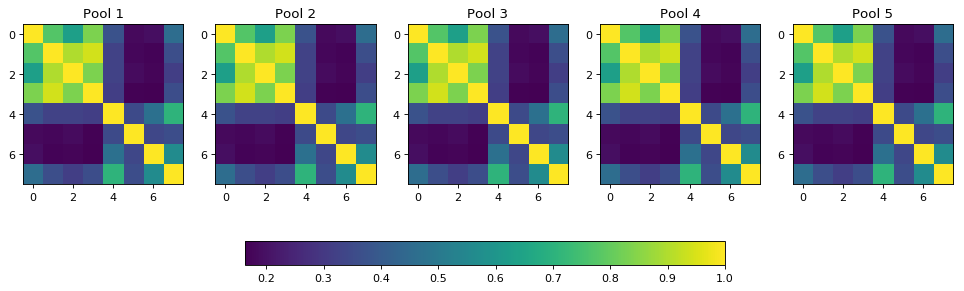

In [75]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


for pool_layer in xrange(0,5):
    pltname = "Pool " + str(pool_layer + 1)
    plt.subplot(1, 5, pool_layer + 1)
    plt.title(pltname)
    plt.imshow(RDM_pool[i])

print OBJECTS
# plt.subplot(336)
# plt.imshow(RDM_fc7)

# plt.subplot(337)
# plt.imshow(RDM_fc6)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal', ax=cax)
plt.show()

In [76]:
print "If the fc6 and fc7 RDM look similar, they are-- note:"
# print "Taking the difference between fc6 and fc7, we have: "  + str((pool[0] - pool[1]).max())
print "Taking the difference between RDM of pooling layers, we have: " + str((RDM_pool[0] - RDM_pool[1]).max())

print getMeanVector(pool[0], NUM_VIEWS, len(OBJECTS)).shape
print "here we have" + str(getMeanVector(pool[1], NUM_VIEWS, len(OBJECTS)).shape)

print pool[1].shape
print pool[0].shape

If the fc6 and fc7 RDM look similar, they are-- note:
Taking the difference between RDM of pooling layers, we have: 0.0
(8, 802816)
here we have(8, 401408)
(320, 401408)
(320, 802816)


In [12]:
print "If the fc6 and fc7 RDM look similar, they are-- note:"
print "Taking the difference between fc6 and fc7, we have: "  + str((fc6 - fc7).max())
print "Taking the difference between RDM of fc6 and fc7, we have: " + str((RDM_fc6 - RDM_fc7).max())

If the fc6 and fc7 RDM look similar, they are-- note:
Taking the difference between fc6 and fc7, we have: 32.3581
Taking the difference between RDM of fc6 and fc7, we have: 0.0470156385361
